In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

In [11]:
df = pd.read_csv('../data/source data/BTC-USD.csv')

length = 14

In [12]:
def calc_rsi(over: pd.Series, fn_roll: Callable) -> pd.Series:
    # Get the difference in price from previous step
    delta = over.diff()
    # Get ride of the header
    delta = delta[1:] 

    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.clip(lower=0), delta.clip(upper=0).abs()

    roll_up, roll_down = fn_roll(up), fn_roll(down)
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

    # Avoid division-by-zero if `roll_down` is zero
    # This prevents inf and/or nan values.
    rsi[:] = np.select([roll_down == 0, roll_up == 0, True], [100, 0, rsi])
    rsi.name = 'rsi'

    # Assert range
    valid_rsi = rsi[length - 1:]
    assert ((0 <= valid_rsi) & (valid_rsi <= 100)).all()
    # Note: rsi[:length - 1] is excluded from above assertion because it is NaN for SMA.

    return rsi

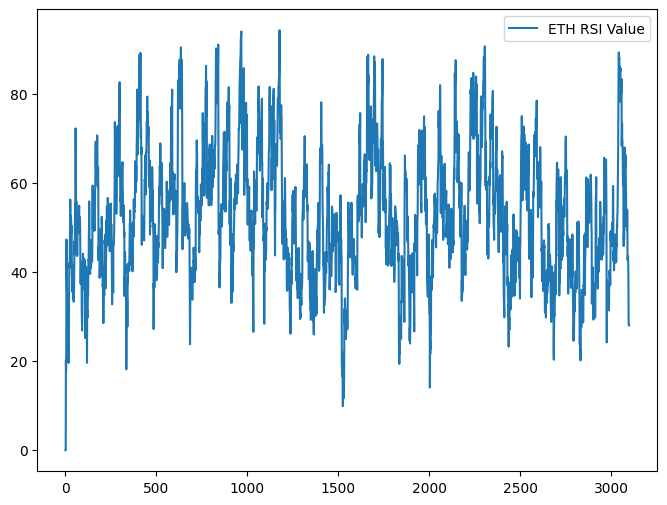

In [13]:
# rsi_ema = calc_rsi(close, lambda s: s.ewm(span=length).mean())
# rsi_sma = calc_rsi(close, lambda s: s.rolling(length).mean())|
rsi_rma = calc_rsi(df['Close'], lambda s: s.ewm(alpha=1 / length).mean())  # Approximates TradingView.
df['RSI'] = rsi_rma
df = df.drop([0,1])

# Graph
plt.figure(figsize=(8, 6))
rsi_rma.plot()
plt.legend(['ETH RSI Value'])
plt.show()

In [14]:
df['RSI-status'] = pd.Series(dtype=str)

for index, row in df.iterrows():
    if row['RSI'] > 70:
        df.loc[index, 'RSI-status'] = 'Overbought'
    elif row['RSI'] < 30:
        df.loc[index, 'RSI-status'] = 'Oversold'
    else:
        df.loc[index, 'RSI-status'] = 'Normal'

In [15]:
# Counter for the check to start after the first week:
counter = 0
df['RSI-decision'] = pd.Series(dtype=str)

for index, row in df.iterrows():
    if counter >= 7:
        last_7_rsi = df.loc[index-6:index, 'RSI']  # get last 7 RSI values
        mean_rsi = last_7_rsi.mean()  # calculate mean of last 7 RSI values
        if row['RSI'] > 70 and row['RSI'] < mean_rsi:
            df.loc[index, 'RSI-decision'] = 'Sell'
        elif row['RSI'] < 30 and row['RSI'] > mean_rsi:
            df.loc[index, 'RSI-decision'] = 'Buy'
        else:
            df.loc[index, 'RSI-decision'] = 'Hold'
    else:
        if row['RSI'] > 70:
            df.loc[index, 'RSI-decision'] = 'Sell'
        elif row['RSI'] < 30:
            df.loc[index, 'RSI-decision'] = 'Buy'
        else:
            df.loc[index, 'RSI-decision'] = 'Hold'
    counter += 1

In [16]:
df.to_csv('ethereum-data.csv')